In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from tqdm import tqdm

import sys
sys.path.append('D:\myProjects\diplom_2\GIT_stencil-net\GIT_stencil-net')
import my_funcs as mf


# import my_advection_funcs as maf

from utils import burgers_simulation

## STENCIL-NET

In [2]:
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from stencilnet import MLPConv, forward_rk3_error, backward_rk3_error#,backward_rk3_tvd_error,forward_rk3_tvd_error
# from stencilnet import forward_rk1_error,backward_rk1_error
from utils import load_simulation_model

##### 0. Mesh Params

In [3]:
# generate_flg=True # True - генерация, False - чтение уже сгенерированных
# # generate_flg=False

# n=101 #число узлов
# L=1 # длина расчт области
# T=.8 #конечное время
# kurant=1

# h=L/(n-1)
# b=(n-1)*0.1*L #width % of L (длина участка с v=1, составляет 10% от расчт области)
# v=[1 if i in range(1,int(b)+1) else 0 for i in range(0,n) ]
# print('Доля единиц:',np.round(100*v.count(1)/len(v),3))

##### 1. Study params

In [4]:
main_params=pd.read_excel('init_params.xlsx',dtype={'has_backward':bool})
main_params=main_params.set_index('param')
display(main_params)

,value
param,
seed,1
method,RK3
decay_const,0.9
train_split,0.5
m,4
epochs,100
l_wd,0.0
fs,7
neurons,64


In [5]:
#------------------------MAIN PARAMS-----------------------------
# size of filter to be applied
fs = int(main_params.loc['fs'])

# number of timesteps to be predicted during training 
m = int(main_params.loc['m'])

# decaying weights
decay_const = float(main_params.loc['decay_const'])

# epoch_number
epochs=int(main_params.loc['epochs'])

#random_seed
seed = int(main_params.loc['seed'])

#coef для loss функции
l_wd= float(main_params.loc['l_wd'])

# 'RK3' for runge-kutta solver and 'E1' for euler solver
method=str(main_params.loc['method'].values[0]) 

#neurons num in MLPConv
neurons=int(main_params.loc['neurons'])

#learning_rate
lr=float(main_params.loc['lr'])

#train_size
train_split=float(main_params.loc['train_split'])

# on/off bwd
has_backward=eval(main_params.loc['has_backward'].values[0])

#hidden_layers_num
hidden_layers_num=int(main_params.loc['hidden_layers_num'])

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##### 2. Generate data

In [6]:
# # CUSTOM_TAU=0.01
# CUSTOM_TAU=0.009
# # CUSTOM_TAU=kurant*h**2
# v_fact,x_lst,tau,time_lst=maf.generate_data(generate_flg,v,T,L,1,h,n,CUSTOM_TAU=CUSTOM_TAU,save_flg=False)

In [7]:
np.random.seed(0)

L = 2.0*np.pi; T_ = 40;  Al = -0.1; Ar = 0.1; wl = -0.4; wr = 0.4; N = 20
A = np.zeros((N,)); w = np.zeros((N,)); phi = np.zeros((N,)); l = np.zeros((N,))

for k in range(0, N):
    A[k] = (Ar-Al)*np.random.rand(1) + Al
    w[k] = (wr-wl)*np.random.rand(1) + wl
    phi[k] = (2.0*np.pi)*np.random.rand(1)
    l[k] = np.random.randint(2, 5)

In [8]:
# Lx = 256; Tsim = 80001;
# Lx = 101; Tsim = 10001;
n = 64; Tsim = 2001;
x_lst = np.linspace(0,L,n); h = x_lst[1] - x_lst[0]; D = 0.02; tau = 0.01

CFL = (h*h)/(2.0*D)
print("CFL dt", CFL, "actual dt", tau)

v_fact, phase = burgers_simulation(Tsim, n, x_lst, D, tau, A, w, phi, l, N, L)

CFL dt 0.24866728145853761 actual dt 0.01


100%|██████████| 2000/2000 [00:02<00:00, 785.70it/s]


In [29]:
v_fact

array([[ 1.23409804e-04, -1.29223780e-03, -2.70903083e-03, ...,
         5.82695259e-01,  5.82901404e-01,  5.83106486e-01],
       [ 2.22285472e-04, -1.29781932e-03, -2.81302413e-03, ...,
         6.19607207e-01,  6.19818404e-01,  6.20028159e-01],
       [ 3.92493899e-04, -1.10121124e-03, -2.59247484e-03, ...,
         6.39155461e-01,  6.39353714e-01,  6.39550194e-01],
       ...,
       [ 7.41571898e-05, -8.96983093e-04, -1.86250031e-03, ...,
         4.00717727e-01,  4.00822147e-01,  4.00927070e-01],
       [ 3.96917201e-05, -1.17046798e-03, -2.37580359e-03, ...,
         4.73701068e-01,  4.73861074e-01,  4.74020978e-01],
       [ 2.08260540e-05, -1.38443625e-03, -2.78074368e-03, ...,
         5.31574028e-01,  5.31756962e-01,  5.31939284e-01]],
      shape=(64, 2001))

##### 2.2 view dynamic of solution

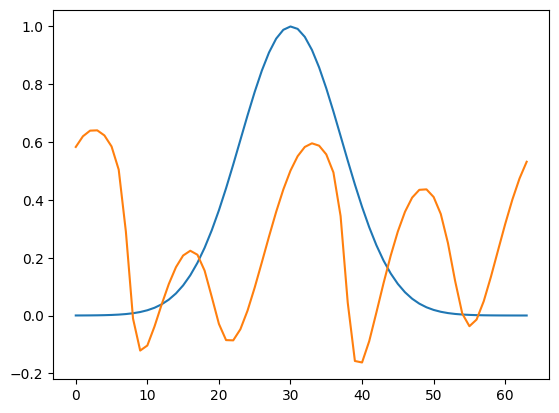

In [9]:
for j in range(0,len(v_fact[0,:]),2000):
# for j in range(0,2,1):
    plt.plot(v_fact[:,j])

In [10]:
print('h',h,h**2)
print('tau',tau)
assert tau/h<=1,'не выполнено ограничение на число Куранта'

h 0.09973310011396169 0.009946691258341505
tau 0.01


Text(0.5, 1.0, 'Фактические данные')

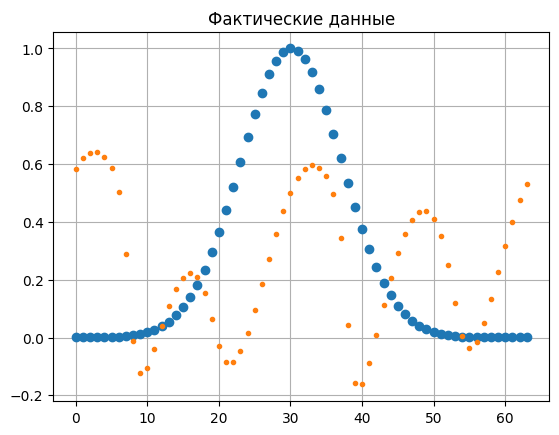

In [11]:
#view
plt.plot(v_fact[:,0],'o')
plt.plot(v_fact[:,-1],'.')
plt.grid()
plt.title('Фактические данные')

##### 3.Subsample Data

In [12]:
t_factor = 1  # time subsample factor 
s_factor = 1   # space subsample factor
Tsim=len(v_fact[0])
dxc,dtc,coarse_t,coarse_x,v_coarse,Lxc,\
Ltc,v_coarse_train,v_coarse_test=mf.subsampling(s_factor,t_factor,h,tau,Tsim,n,v_fact,train_split=train_split)

full_sample (64, 2001)
train (64, 1000)
test (64, 1001)


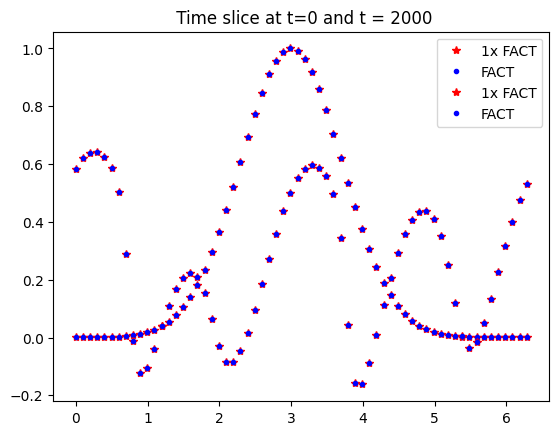

In [13]:
plt.figure()
time=0 #first time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.',color='blue',label='FACT')
time=v_coarse.shape[1]-1 #last time
plt.plot(x_lst[coarse_x],v_coarse[:,time],'*',color='red',label=str(s_factor) + 'x FACT')
plt.plot(x_lst,v_fact[:,t_factor*time],'.',color='blue',label='FACT')
plt.legend()
plt.title(" Time slice at t=0 and t = " + str(time))
plt.show()

In [31]:
v_coarse_train

array([[ 1.23409804e-04, -1.29223780e-03, -2.70903083e-03, ...,
         3.04533395e-01,  3.03845298e-01,  3.03153266e-01],
       [ 2.22285472e-04, -1.29781932e-03, -2.81302413e-03, ...,
        -2.22345104e-01, -2.22518313e-01, -2.22694866e-01],
       [ 3.92493899e-04, -1.10121124e-03, -2.59247484e-03, ...,
        -4.07151874e-01, -4.06887857e-01, -4.06623854e-01],
       ...,
       [ 7.41571898e-05, -8.96983093e-04, -1.86250031e-03, ...,
         6.69061732e-01,  6.68732575e-01,  6.68402954e-01],
       [ 3.96917201e-05, -1.17046798e-03, -2.37580359e-03, ...,
         6.42619205e-01,  6.42217779e-01,  6.41815919e-01],
       [ 2.08260540e-05, -1.38443625e-03, -2.78074368e-03, ...,
         5.67692241e-01,  5.67193852e-01,  5.66694443e-01]],
      shape=(64, 1000))

##### 4. Trainig model

In [14]:
# initialize the different forcing terms at current timestep,
# half and full timestep into past (m) and future (p)

from utils import forcing_terms

Fc, Fc_0p5, Fc_p1, Fc_0m5, Fc_m1 = forcing_terms(A, w, phi, l, L, Lxc, T_, Ltc, N, dtc)

u_train = torch.tensor(v_coarse_train.T, requires_grad=True, dtype=torch.float, device=device)
fc      = torch.tensor(Fc.T, requires_grad=True, dtype=torch.float, device=device)
fc_0p5  = torch.tensor(Fc_0p5.T, requires_grad=True, dtype=torch.float, device=device)
fc_p1   = torch.tensor(Fc_p1.T, requires_grad=True, dtype=torch.float, device=device)
fc_0m5  = torch.tensor(Fc_0m5.T, requires_grad=True, dtype=torch.float, device=device)
fc_m1   = torch.tensor(Fc_m1.T, requires_grad=True, dtype=torch.float, device=device)

In [20]:
net, loss_lst,loss=mf.train_net(MLPConv,v_coarse_train,epochs,dtc,
              fs,
              neurons,
              hidden_layers_num,
              lr,
              m,
              has_backward,
              method,
              decay_const,
              force_terms=[fc,fc_0p5,fc_p1,fc_0m5,fc_m1])

input 7 output 64
input 64 output 64
input 64 output 64
input 64 output 1
#parameters: 8897


100%|██████████| 100/100 [01:40<00:00,  1.01s/it, loss=0.00019]


In [27]:
v_coarse_train.shape

(64, 1000)

In [32]:
net.parameters

<bound method Module.parameters of MLPConv(
  (sig): ELU(alpha=1.0)
  (layer): ModuleList(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1-2): 2 x Linear(in_features=64, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)>

In [25]:
epochs,dtc,\
              fs,\
              neurons,\
              hidden_layers_num,\
              lr,\
              m,\
              has_backward,\
              method,\
              decay_const

(100, 0.01, 7, 64, 3, 0.001, 4, True, 'RK3', 0.9)

In [16]:
# mf.plot_err_and_components_of_err(np.array(loss_lst))

##### 5. save_model

In [21]:
torch.save(net, './models/model_burgers_n=' +str(n)+'_'+ str(fs) + "_"+str(t_factor) +'L_' + str(neurons) + '_ep_' + str(epochs)  + '_' + "elu" + '_m' + str(m) + '_Lxc' +  str(s_factor) + "_Ltc" + str(t_factor) +  '_lwd' + str(l_wd) +fr'_WDact{method}_seed_'+ str(seed)  + '.pth')

In [18]:
# net.layer[-1].weight

##### 6. load_model

In [22]:
# neurons = 64
# fs=7
# epochs=100
# m=4
# l_wd=0#1e-3
# seed=1
#method='E1'

# net = load_simulation_model(s_factor, t_factor, neurons, device)
# net=torch.load('./models/model_burgers_n=' +str(n)+'_' + str(fs) + "_"+str(t_factor) +'L_' + str(neurons) + '_ep_' + str(epochs)  + '_' + "elu" + '_m' + str(m) + '_Lxc' +  str(s_factor) + "_Ltc" + str(t_factor) +  '_lwd' + str(l_wd) +fr'_WDact{method}_seed_'+ str(seed)  + '.pth')

In [23]:
net.layer[-1].weight

Parameter containing:
tensor([[ 0.0374, -0.0309,  0.0243, -0.0815,  0.2814, -0.0945, -0.3136, -0.0477,
         -0.0349, -0.3200, -0.2271, -0.0518,  0.2641,  0.0943, -0.1494,  0.1011,
          0.1490,  0.0156, -0.0695, -0.2702,  0.2060,  0.0553,  0.1465,  0.0838,
          0.2095, -0.1955, -0.4089,  0.2812, -0.0532, -0.2260,  0.0073,  0.4838,
         -0.1051,  0.1639, -0.1496,  0.0855,  0.0038,  0.1047,  0.0961,  0.0744,
         -0.3260,  0.1959,  0.1055, -0.5268, -0.2589, -0.0695,  0.0616, -0.0252,
          0.2431, -0.3082, -0.2821, -0.4881, -0.3572,  0.2263, -0.0320, -0.3431,
          0.1522,  0.0024, -0.0930, -0.0898,  0.1535,  0.0435, -0.0627, -0.0236]],
       requires_grad=True)

##### 7. Simulation

In [33]:
NN_sim,T_sim,x_sim=mf.make_simulation_forcing(net,v_coarse,L,Lxc,dtc,\
                                              A,phi,N,w,l)


# NN_sim,T_sim,x_sim=mf.make_simulation_forcing_old(net,v_coarse,L,Lxc,dtc,\
                                            #   A,phi,N,w,l)

RK3


100%|██████████| 2000/2000 [00:05<00:00, 359.76it/s]


##### 8. view_results_old

In [ ]:
# mf.view_results_old(T_sim,x_sim,NN_sim,v_coarse,T,dtc)

In [ ]:
# didnt work, what is T ????
# mf.view_result_imshow_old(NN_sim,v_coarse,2,dtc,L,dxc,n_xticks=100)

#### 9. view results new

In [34]:
T=round(T_sim*dtc,3)
T

20.01

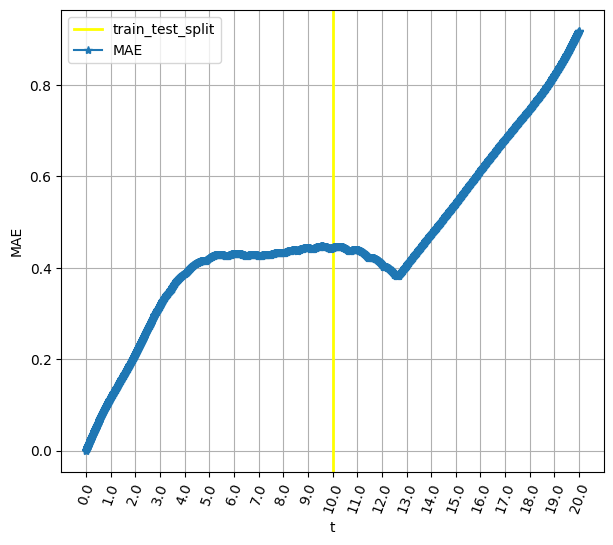

In [35]:
folder='Burgers_graphs'

mf.view_results(T_sim,x_sim,NN_sim,v_coarse,T,dtc,n=11,fix_axes=False,
                epochs=epochs,
                save_path = fr'{folder}/graphs/',
                save_name = fr'Result_epoch={epochs}',
                view_flag=False)

mf.view_result_metric(NN_sim,v_coarse,T,dtc,L,dxc,
                       n_xticks=100,
                       save_path = fr'{folder}/graphs/',
                save_name = fr'Metric_epoch={epochs}')

mf.make_gif(folder=fr'{folder}/graphs/',epochs=epochs)

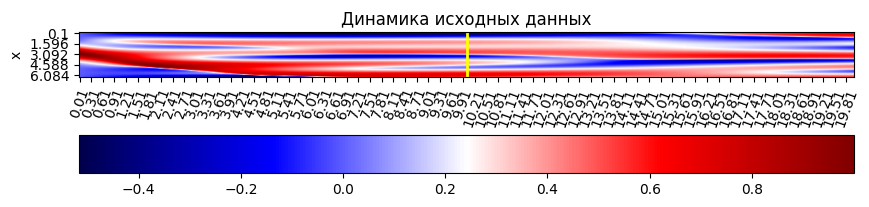

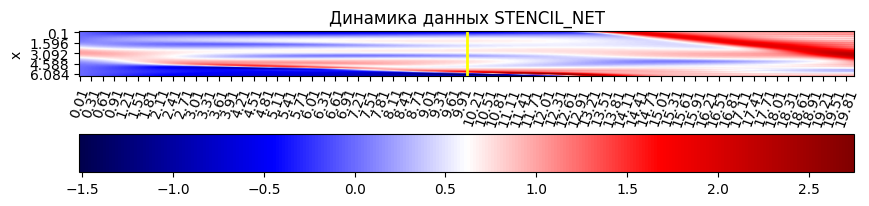

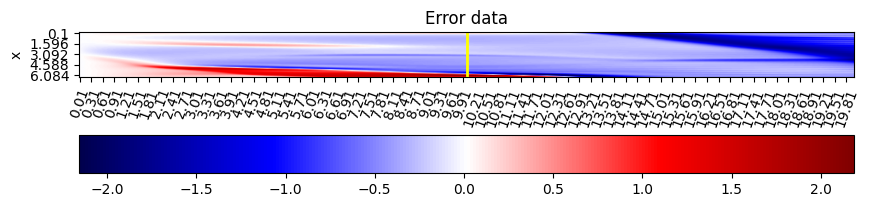

In [36]:
mf.view_result_imshow(NN_sim, v_coarse, T-dtc, dtc, L, dxc,
                          n_xticks=30,n_yticks=15,
                          figsize=(10,5),
                          save_path=fr'{folder}/graphs/',
                          save_name=fr'Imshow_epoch={epochs}',
                          view_flg=True,
                          fix_colorbar_axes=False
                          )

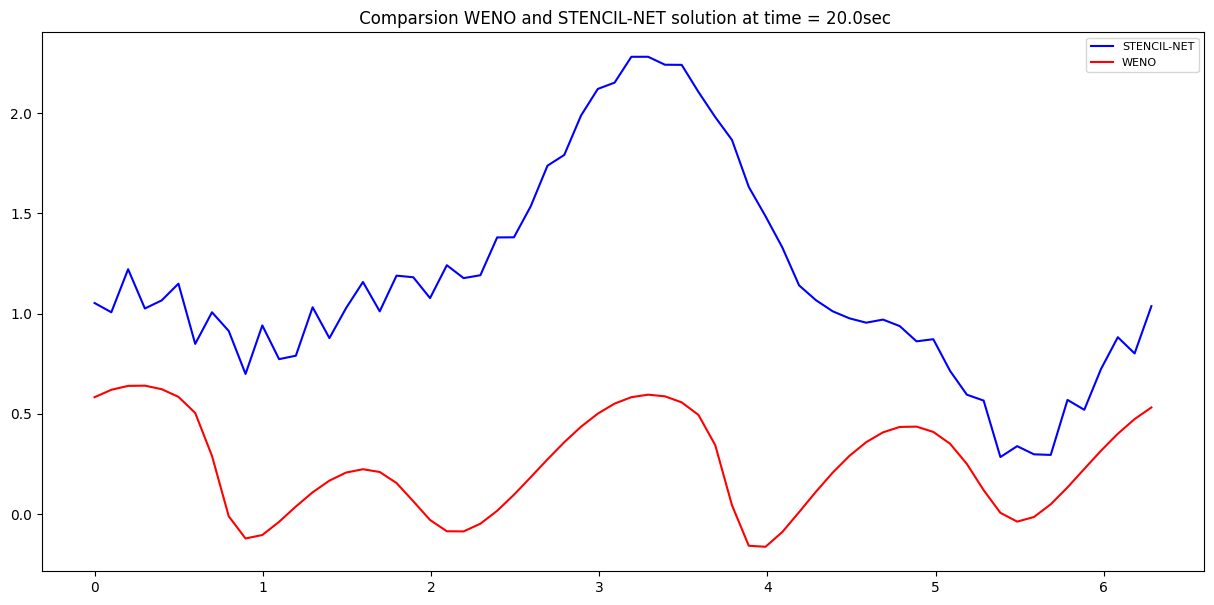

In [37]:
time = 2000

plt.title(" Comparsion WENO and STENCIL-NET solution at time = " + str(time*dtc) + "sec")
plt.plot(x_sim,NN_sim[:,time],'-',color='blue',label='STENCIL-NET')
plt.plot(x_sim,v_coarse[:,time],color='red', label='WENO')
plt.legend(loc='best', prop={'size':8})

plt.gcf().set_size_inches(15,7)

In [ ]:
v_coarse[:,0]

In [ ]:
has_backward

##### 9. save weights

In [ ]:
# folder_to_save_weights='data/output/weight/'

In [ ]:
# k=0
# for layer in net.layer:
#     pd.DataFrame(layer.weight.data.numpy()).to_csv(folder_to_save_weights+fr'weigth_{k}.csv')
#     pd.DataFrame(layer.bias.data.numpy()).to_csv(folder_to_save_weights+fr'bias_{k}.csv')
#     k+=1

In [ ]:
# pd.DataFrame(net.layer[0].weight.data.numpy())